In [1]:
import requests 
from requests.auth import HTTPBasicAuth
import json 
import numpy as np
import pandas as pd

In [2]:

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from tqdm import tqdm_notebook
from itertools import product

import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

In [3]:
api_key = "94d15fb2-75c4-4439-97bb-9927089c6698"
server_url = 'https://esgf-server-staging.herokuapp.com'
service_name = 'get_inference_data'
params = f"?api_key={api_key}"
headers = {
       'Accept': 'application/json',
       'Authorization' : f"Bearer {api_key}"
}
response = requests.get(f"{server_url}/{service_name}{params}", headers=headers)
print(response.text)
assert response.status_code == 200

{"id":"7Rv3y2Jz0h1QTCE1","x":"{\"wconfid\":{\"0\":1,\"1\":1,\"2\":1,\"3\":1,\"4\":1,\"5\":1,\"6\":1,\"7\":1,\"8\":1,\"9\":1,\"10\":1,\"11\":1,\"12\":1,\"13\":1,\"14\":1,\"15\":1,\"16\":1,\"17\":1,\"18\":1,\"19\":1,\"20\":1,\"21\":1,\"22\":1,\"23\":1,\"24\":1,\"25\":1,\"26\":1,\"27\":1,\"28\":1,\"29\":1,\"30\":1,\"31\":1},\"pctid\":{\"0\":85,\"1\":85,\"2\":85,\"3\":85,\"4\":85,\"5\":85,\"6\":85,\"7\":85,\"8\":85,\"9\":85,\"10\":85,\"11\":85,\"12\":85,\"13\":85,\"14\":85,\"15\":85,\"16\":85,\"17\":85,\"18\":85,\"19\":85,\"20\":85,\"21\":85,\"22\":85,\"23\":85,\"24\":85,\"25\":85,\"26\":85,\"27\":85,\"28\":85,\"29\":85,\"30\":85,\"31\":85},\"x\":{\"0\":-0.621,\"1\":4.059,\"2\":0.988,\"3\":2.324,\"4\":0.594,\"5\":2.203,\"6\":0.34,\"7\":-1.254,\"8\":0.949,\"9\":-0.699,\"10\":-1.516,\"11\":-0.586,\"12\":3.75,\"13\":1.195,\"14\":0.773,\"15\":0.492,\"16\":0.516,\"17\":-0.801,\"18\":1.305,\"19\":0.602,\"20\":-0.5,\"21\":2.133,\"22\":-0.484,\"23\":1.875,\"24\":1.113,\"25\":4.359,\"26\":1.465,\"2

Sample

In [4]:
# Server answer as json. Dictionary with keys 'id' and 'x'
json_answer = response.json()

# Example id
example_id = json_answer['id']

# Parse str answer as json object
json_answer = json.loads(json_answer['x'])

# Frame answer
pd_sample = pd.DataFrame(json_answer)

# Logs. You should have (32,5).
print("Sample ID='{}' has shape {}".format(example_id, pd_sample.shape))

Sample ID='7Rv3y2Jz0h1QTCE1' has shape (32, 5)


In [5]:
pd_sample

,wconfid,pctid,x,y,z
0,1,85,-0.621,-0.305,-0.082
1,1,85,4.059,2.387,-1.699
2,1,85,0.988,2.469,0.312
3,1,85,2.324,0.547,-0.477
4,1,85,0.594,-0.648,-0.523
5,1,85,2.203,-0.535,-1.047
6,1,85,0.340,0.746,0.270
7,1,85,-1.254,1.113,-1.363
8,1,85,0.949,-0.133,-0.789
9,1,85,-0.699,-0.668,-0.957


In [6]:
print(pd_sample.shape)  # (32, 5)
pd_sample.tail()
     

(32, 5)


,wconfid,pctid,x,y,z
27,1,85,1.977,1.102,0.438
28,1,85,2.266,-1.102,0.340
29,1,85,-0.418,-1.598,0.762
30,1,85,1.281,-0.227,-0.785
31,1,85,-0.965,0.672,0.328


In [7]:
macro_data = pd_sample[['x','y','z']]
print(macro_data.shape)

(32, 3)


In [8]:
train_df=macro_data[:-12]
test_df=macro_data[-12:]

In [9]:
print(test_df.shape)

(12, 3)


In [10]:
model = VAR(train_df.diff()[1:])

In [11]:
sorted_order=model.select_order(maxlags=3)
print(sorted_order.summary())


 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0       2.683      2.828*       14.63       2.690
1       2.592       3.172       13.80       2.622
2       2.521       3.535       15.04       2.573
3      1.618*       3.066      9.647*      1.692*
-------------------------------------------------


In [12]:
var_model = VARMAX(train_df, order=(4,0),enforce_stationarity= True)
fitted_model = var_model.fit(disp=False)
print(fitted_model.summary())

                           Statespace Model Results                           
Dep. Variable:        ['x', 'y', 'z']   No. Observations:                   20
Model:                         VAR(4)   Log Likelihood                 -33.182
                          + intercept   AIC                            156.365
Date:                Sat, 04 Feb 2023   BIC                            201.173
Time:                        19:13:12   HQIC                           165.112
Sample:                             0                                         
                                 - 20                                         
Covariance Type:                  opg                                         
Ljung-Box (L1) (Q):       0.16, 0.05, 1.77   Jarque-Bera (JB):      0.24, 0.67, 0.15
Prob(Q):                  0.69, 0.82, 0.18   Prob(JB):              0.89, 0.71, 0.93
Heteroskedasticity (H):   0.08, 0.68, 1.33   Skew:               -0.08, -0.23, -0.12
Prob(H) (two-sided):      0.00, 0.

In [13]:
n_forecast = 300
predict = fitted_model.get_prediction(start=len(train_df),end=len(train_df) + n_forecast-1)

predictions=predict.predicted_mean


In [14]:
predictions.columns=['x_predicted','y_predicted','z_predicted']
predictions

,x_predicted,y_predicted,z_predicted
20,0.144440,-0.404637,0.355133
21,0.730408,-0.574368,0.306656
22,1.421568,0.761304,-1.054882
23,0.948114,1.037974,-0.011140
24,0.729919,0.729292,-0.360890
...,...,...,...
315,0.721245,0.215599,-0.422792
316,0.719783,0.212454,-0.421718
317,0.718303,0.208802,-0.421500
318,0.718504,0.208854,-0.422357


***" t= 32	     //          x= 0.972211	  //               y=0.002333	      //               z =-0.112556"***

In [15]:
test_vs_pred=pd.concat([test_df,predictions],axis=1)

<AxesSubplot:>

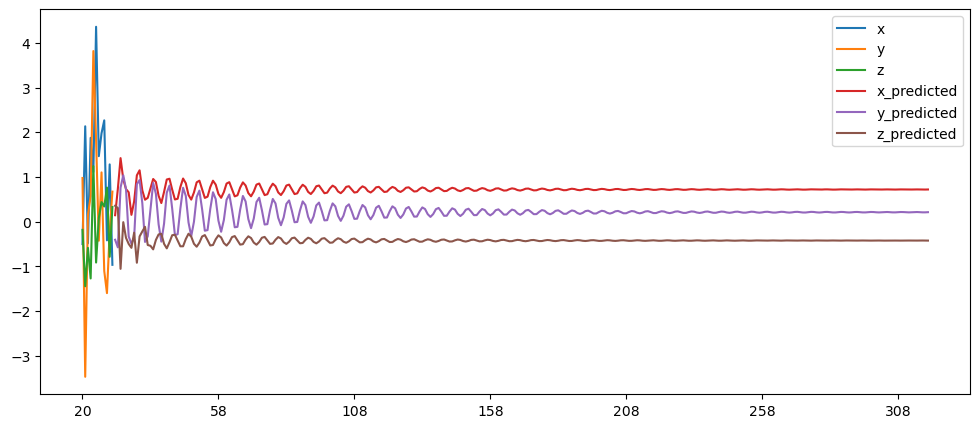

In [16]:
test_vs_pred.plot(figsize=(12,5))

***" t= 32	     //          x= 0.972211	  //               y=0.002333	      //               z =-0.112556"***

In [17]:
import pickle
model_input = (2,65)

In [18]:
filename = 'TP4_model.sav'
pickle.dump(var_model, open(filename, 'wb'))

In [19]:
# loading the saved model
loaded_model = pickle.load(open('TP4_model.sav', 'rb'))

In [20]:
#var_model.predict([[2,100]])